----

In [1]:
# imports
import pandas as pd; import missingno as msno; import matplotlib.pyplot as plt; import seaborn as sns;import numpy as np;import warnings
from sklearn import preprocessing; from scipy import stats; import networkx as nx
import pygraphviz as pgv; from networkx.drawing.nx_agraph import graphviz_layout,from_agraph, to_agraph; import graphviz

# settings
np.seterr(divide='warn', invalid='warn'); sns.set_style("whitegrid");warnings.filterwarnings('ignore')

-----

# Project: Bosch Manufacturing Line

__Author:__ [Ryan Harper](www.kimrharper.com) <br><br>
__Data Source:__ [Bosch Dataset via Kaggle](https://www.kaggle.com/c/bosch-production-line-performance/data) <br> <br>
__Background:__ Bosch is a home appliance and industrial tools manufacturing company. In 2017, Bosch supplied Kaggle.com with manufacturing data to promote a competition. The goal of the competition was to determine factors that influence whether or not the product passes the final response stage of manufacturing and to predict which products are likely to fail based on this manufacturing process.<br> <br>
__The Data:__ Early exploration of this data will use a subset of the big data provided by Bosch. The data is provided by [Hitesh, John, and Matthew via PDX Data Science Meetup](https://www.meetup.com/Portland-Data-Science-Group/events/257370691/). The data subset is divided into 2 groups of 3 files (3 training, 3 test). Each group has one csv file each for numerical features ('numeric'), dates ('date'), and the manufacturing path ('cat'). The data subset includes a larger percentage of products that failed the response test, but not much more is known about this subsampling method.<br><br>
__Assumptions:__ ID # represents a specific product and that there is only one product. The differences in assembly are due to customization and/or differences between lines.<br><br>
__Goal:__ Predict which products will fail the response test. <br><br>

## I. Exploratory Analysis

### A. Numerical Data

In [2]:
%%time
# import numerical data
mf_num_data = pd.read_csv('bosch_small_data/train_numeric.csv',low_memory=False)

CPU times: user 8.94 s, sys: 1.03 s, total: 9.97 s
Wall time: 9.98 s


As the data is extremely large, it is important to explore the structure of the data to get a feel for what is happening. The numerical data appears to be the most important, so I will start with examining the numerical data.

In [3]:
# show data with pandas
mf_num_data.head(2)

,Id,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,...,L3_S50_F4245,L3_S50_F4247,L3_S50_F4249,L3_S50_F4251,L3_S50_F4253,L3_S51_F4256,L3_S51_F4258,L3_S51_F4260,L3_S51_F4262,Response
0,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,71,-0.167,-0.168,0.276,0.33,0.074,0.161,0.052,0.248,0.163,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


There are a lot of missing data and null (NaN) values. It is not obvious if this is due to recording errors (which I suspect is not the case), or if it is related to the structuring of the data. I need to continue visualizing the data.

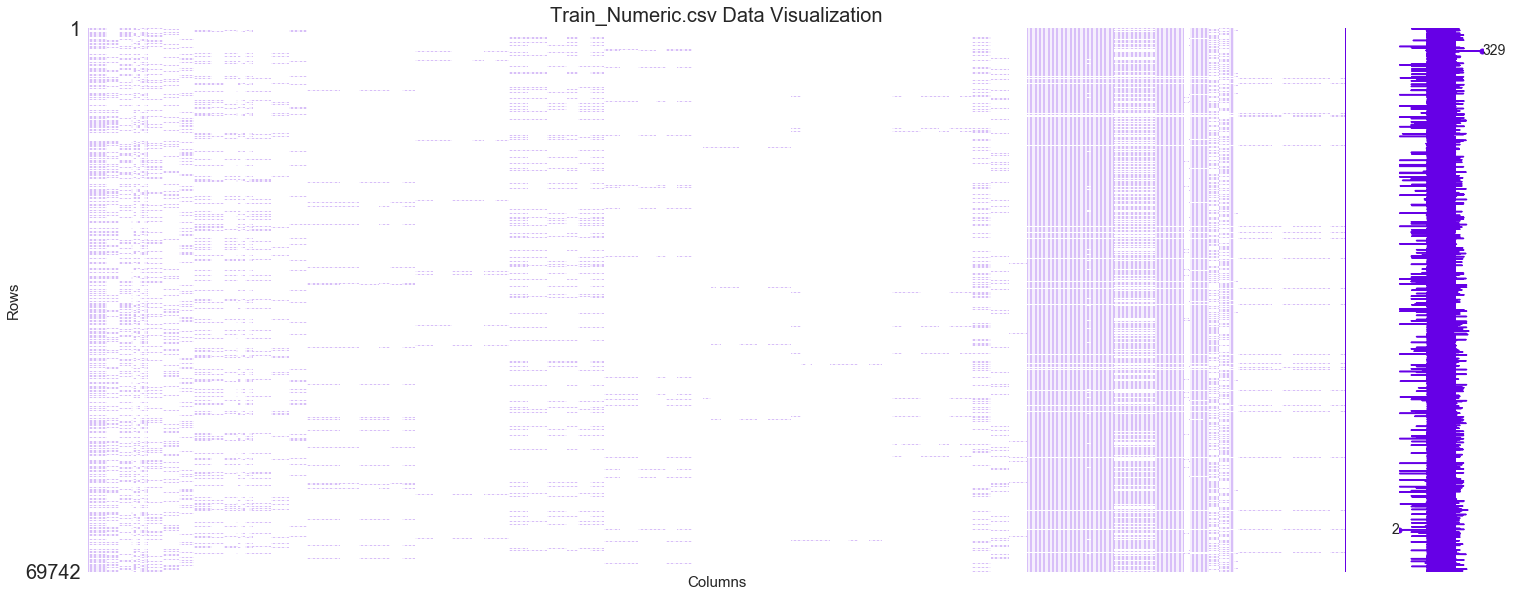

In [4]:
# visualize numerical data with missingno
msno.matrix(mf_num_data, color=(.4,0,.9))
plt.title('Train_Numeric.csv Data Visualization',size=20)
plt.ylabel('Rows',size=15)
plt.xlabel('Columns',size=15)
plt.show()

#msno.dendrogram(mf_num_data)

The graph above shows which values are included (purple) and which values are missing (white). The final column on the right side of the graph shows how many values are included in each row. Every row appears to have at most 20-30% of the columns filled in with values. This graph confirms that the data set is very sparse and reaffirms explanations of the data from the Kaggle site and from Hitesh's presentation on the data. 

In [5]:
# split the strings
columns_set = list(mf_num_data.columns)[1:-1]
breakup_strings = [i.split('_') for i in columns_set]

# store the values in separate containers
line_count = set([i[0] for i in breakup_strings[0:-1]])
station_count = set([i[1] for i in breakup_strings[0:-1]])
feature_count = set([i[2] for i in breakup_strings[0:-1]])

print('Unique lines: {}\nUnique Stations: {}\nUnique Feature Measurements: {}'.format(
    len(line_count),len(station_count),len(feature_count)))

Unique lines: 4
Unique Stations: 50
Unique Feature Measurements: 967


In [6]:
%%time
# function for calculating ratio of failures
def get_ratio(column):
    all_response = mf_num_data[[column,'Response']].dropna()['Response']
    return [column, all_response.sum()/len(all_response)]

# calculate ratio of failures for every columns
vals = [get_ratio(i) for i in mf_num_data.columns[1:-1]]

# sort values and push to df
sorted_corr = pd.DataFrame(vals).sort_values(by=[1],ascending=False)

CPU times: user 4.47 s, sys: 31.4 ms, total: 4.5 s
Wall time: 4.51 s


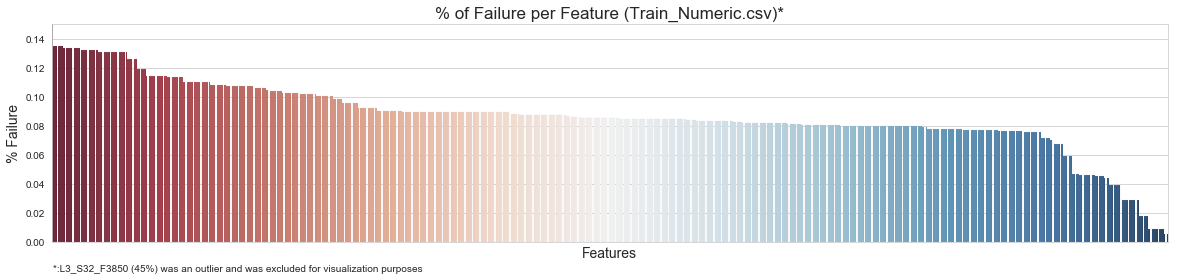

In [7]:
plt.figure(figsize=(20,4))
sns.barplot(x=0,y=1,data=sorted_corr,palette="RdBu",linewidth=.1,edgecolor=".8",orient='v')
plt.xticks([])
plt.xlabel('Features',size=14)
plt.ylabel('% Failure',size=14)
plt.ylim(0,.15)
plt.title('% of Failure per Feature (Train_Numeric.csv)*',size=17)
plt.text(1,-.02, '*:L3_S32_F3850 (45%) was an outlier and was excluded for visualization purposes')
plt.show()

### B. Timeseries Data

In [8]:
%%time
# import date data
mf_date_data = pd.read_csv('bosch_small_data/train_date.csv',low_memory=False)

CPU times: user 10.2 s, sys: 1.16 s, total: 11.3 s
Wall time: 11.4 s


In [9]:
# show data
mf_date_data.head(3)

,Id,L0_S0_D1,L0_S0_D3,L0_S0_D5,L0_S0_D7,L0_S0_D9,L0_S0_D11,L0_S0_D13,L0_S0_D15,L0_S0_D17,...,L3_S50_D4248,L3_S50_D4250,L3_S50_D4252,L3_S50_D4254,L3_S51_D4255,L3_S51_D4257,L3_S51_D4259,L3_S51_D4261,L3_S51_D4263,Response
0,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,71,1458.06,1458.06,1458.06,1458.06,1458.06,1458.06,1458.06,1458.06,1458.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [10]:
def final_time(df,row_ind):
    time = df.iloc[row_ind,1:].dropna().iloc[-2]
    response = df.iloc[row_ind,-1]
    return time,response
final_time(mf_date_data,31)

(302.09, 1.0)

In [11]:
%%time
last_time =[]
for i in range(len(mf_date_data.iloc[:,1:-1])):
    try:
        lt, sc = final_time(mf_date_data,i)
        last_time.append(lt)
    except:
        last_time.append(0)
mf_date_data['final_time'] = last_time
time_series_plot = mf_date_data[['final_time','Response']]

CPU times: user 1min 5s, sys: 595 ms, total: 1min 6s
Wall time: 1min 6s


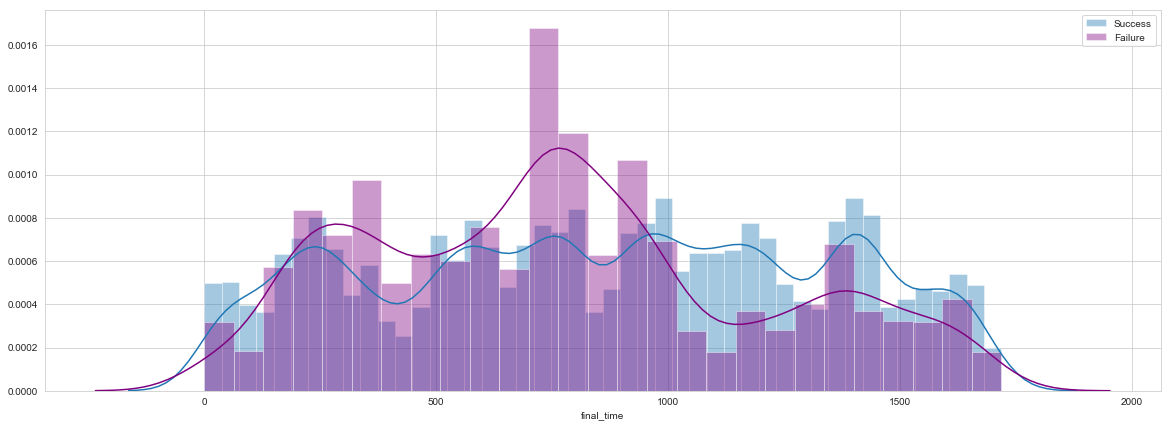

In [12]:
plt.figure(figsize=(20,7))
sns.distplot(time_series_plot['final_time'][time_series_plot['Response']==0])
sns.distplot(time_series_plot['final_time'][time_series_plot['Response']==1],color='purple')
plt.legend(['Success','Failure'])
plt.show()

### C. Graph/Network Data

[F7 Function - Reduce without changing order](https://stackoverflow.com/questions/480214/how-do-you-remove-duplicates-from-a-list-whilst-preserving-order)

In [13]:
def q_rem_dup(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

In [14]:
# checking_sets
new_sets = [set(['_'.join(feature_member.split('_')[0:2]) for feature_member in list(mf_num_data.iloc[i,1:-1].dropna().index)]) for i in range(6000)]
frozenset().union(*new_sets);

In [15]:
%%time
row_count = len(mf_num_data)
network_structure = []
for i in range(row_count):
    feature_group = ['_'.join(feature_member.split('_')[0:2]) for feature_member in list(mf_num_data.iloc[i,1:-1].dropna().index)]
    feature_group = q_rem_dup(feature_group)
    network_structure.append(feature_group)

CPU times: user 2min 22s, sys: 366 ms, total: 2min 23s
Wall time: 2min 23s


In [16]:
# create txt for easy import
file = open('adjaceny.txt','w') 
for l in network_structure:
    if len(l) > 1:
        file.write(' '.join(l)+'\n')
file.close() 

In [17]:
%%time
# Convert txt to networkx
G=nx.read_adjlist("adjaceny.txt", create_using=nx.DiGraph)

# convert networkx to pygraphviz
A=to_agraph(G)

CPU times: user 1.05 s, sys: 9.17 ms, total: 1.05 s
Wall time: 1.05 s


In [71]:
G.node()

NodeView(('L0_S12', 'L0_S13', 'L0_S14', 'L0_S17', 'L0_S18', 'L0_S20', 'L0_S21', 'L3_S29', 'L3_S30', 'L3_S33', 'L3_S34', 'L3_S35', 'L3_S37', 'L0_S0', 'L0_S1', 'L0_S3', 'L0_S4', 'L0_S7', 'L0_S8', 'L0_S11', 'L0_S19', 'L0_S22', 'L3_S31', 'L0_S5', 'L0_S9', 'L3_S36', 'L0_S16', 'L0_S23', 'L0_S6', 'L2_S27', 'L0_S15', 'L1_S24', 'L0_S2', 'L0_S10', 'L2_S26', 'L3_S39', 'L3_S40', 'L3_S41', 'L3_S43', 'L3_S45', 'L3_S47', 'L3_S48', 'L3_S50', 'L3_S51', 'L3_S49', 'L3_S32', 'L1_S25', 'L3_S38', 'L3_S44', 'L2_S28'))

In [77]:
nx.draw_networkx_edges?

Signature: nx.draw_networkx_edges(G, pos, edgelist=None, width=1.0, edge_color='k', style='solid', alpha=1.0, arrowstyle='-|>', arrowsize=10, edge_cmap=None, edge_vmin=None, edge_vmax=None, ax=None, arrows=True, label=None, node_size=300, nodelist=None, node_shape='o', **kwds)
Docstring:
Draw the edges of the graph G.

This draws only the edges of the graph G.

Parameters
----------
G : graph
   A networkx graph

pos : dictionary
   A dictionary with nodes as keys and positions as values.
   Positions should be sequences of length 2.

edgelist : collection of edge tuples
   Draw only specified edges(default=G.edges())

width : float, or array of floats
   Line width of edges (default=1.0)

edge_color : color string, or array of floats
   Edge color. Can be a single color format string (default='r'),
   or a sequence of colors with the same length as edgelist.
   If numeric values are specified they will be mapped to
   colors using the edge_cmap and edge_vmin,edge_vmax parameters.

sty

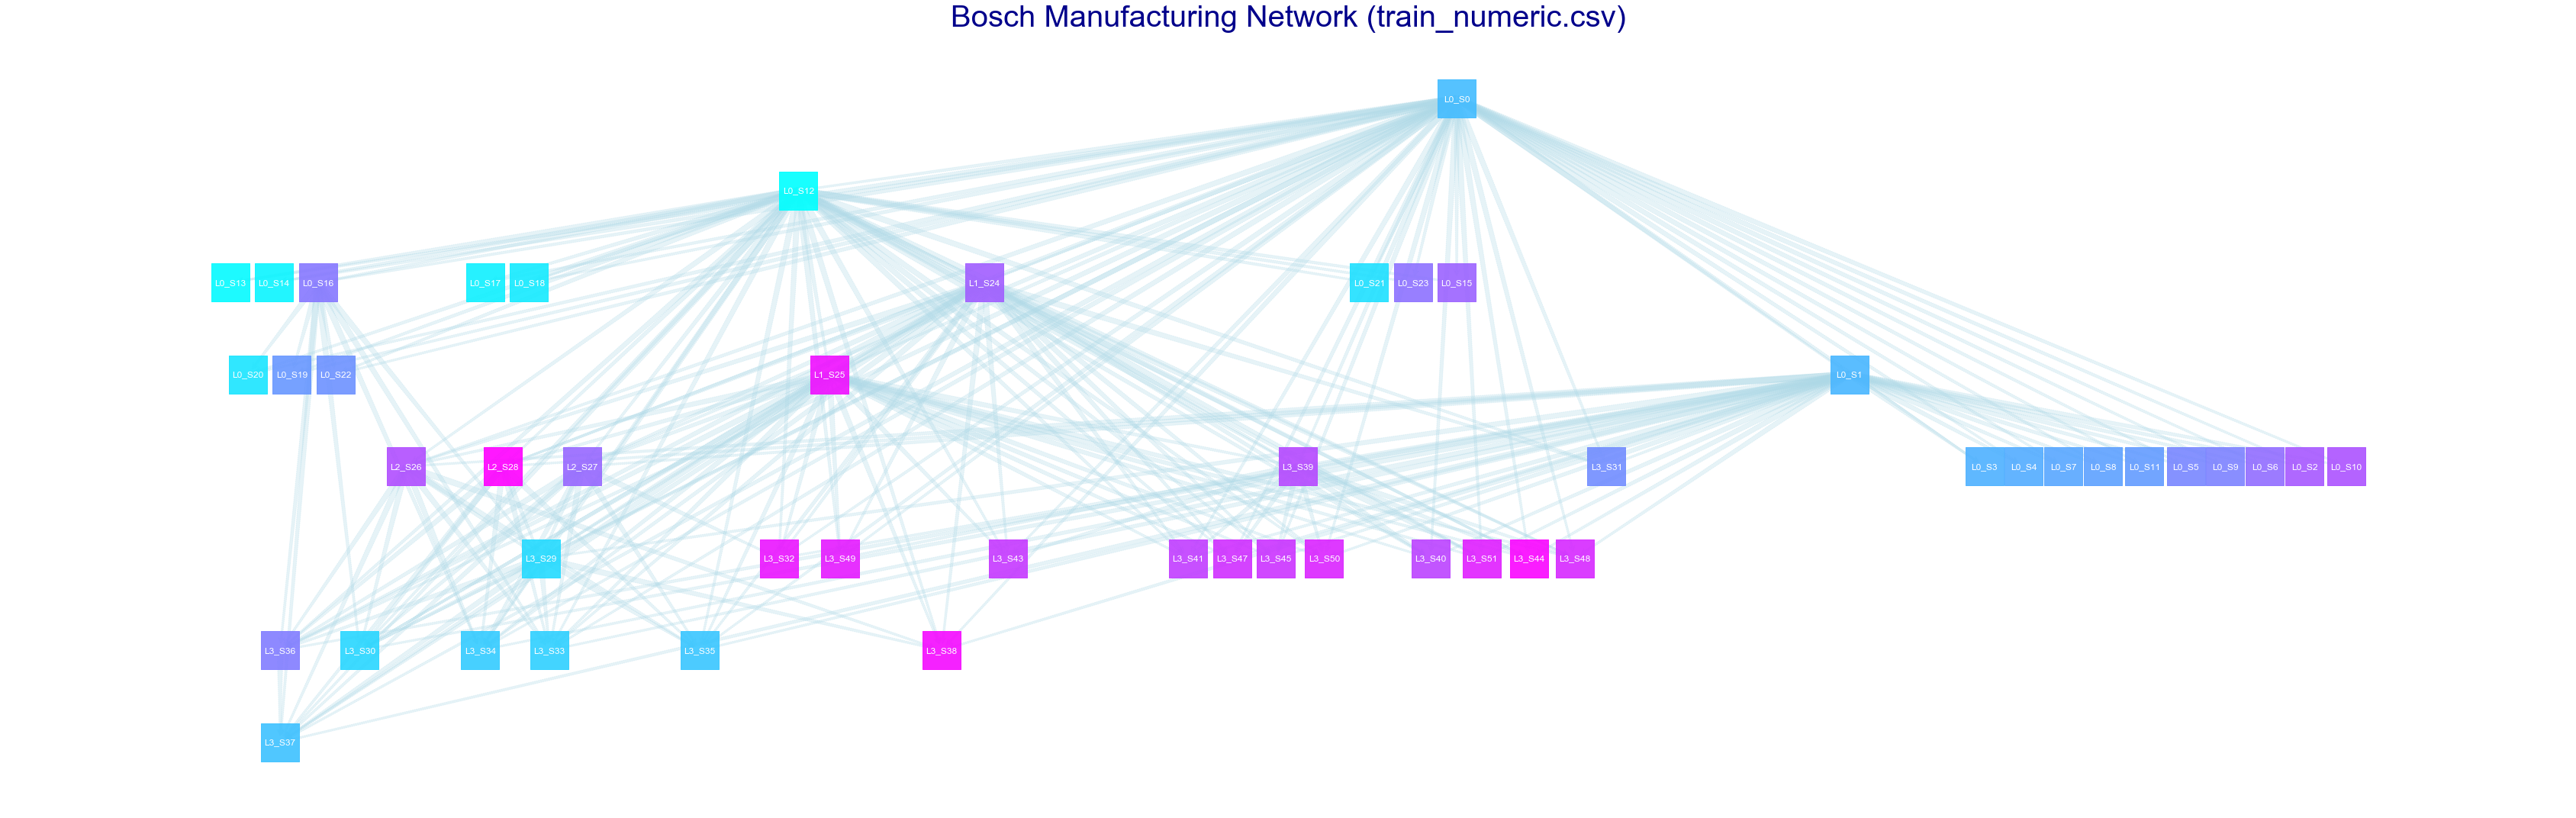

In [114]:
plt.figure(figsize=(47,15))


nx.draw_networkx_nodes(G, 
                       pos=graphviz_layout(G, prog='dot'), 
                       node_size=2500, 
                       cmap=plt.cm.cool,
                       node_shape = 's',
                       node_color=range(len(G)),
                       alpha=.9)

collection = nx.draw_networkx_edges(G,
                       pos=graphviz_layout(G, prog='dot'), 
                       alpha=.3,
                       style='dotted',
                       arrowsize=20,
                       edge_color='lightblue'
                       )
for patch in collection:
    patch.set_linestyle('dotted')
    patch.set_arrowstyle('fancy')


nx.draw_networkx_labels(G,
                        pos=graphviz_layout(G, prog='dot'),
                        font_color='white')

plt.title('Bosch Manufacturing Network (train_numeric.csv)',size=40,color='darkblue')
plt.box(on=None)
fig.patch.set_visible(False)
plt.xticks([])
plt.yticks([])
plt.tight_layout()

plt.savefig('network_modeling2.png',bbox_inches='tight')
plt.show()

In [19]:
mf_network = mf_num_data.where(mf_num_data.isnull(), 1).fillna(0).astype(int)
del mf_network['Id']
del mf_network['Response']

In [20]:
mf_network.head(2)

,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,L0_S0_F18,...,L3_S50_F4243,L3_S50_F4245,L3_S50_F4247,L3_S50_F4249,L3_S50_F4251,L3_S50_F4253,L3_S51_F4256,L3_S51_F4258,L3_S51_F4260,L3_S51_F4262
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


## II. Statistical Analysis

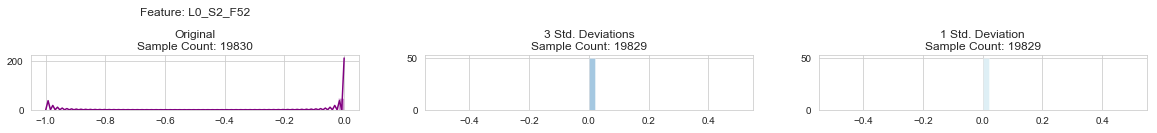

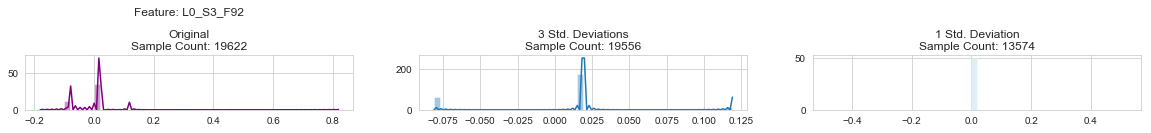

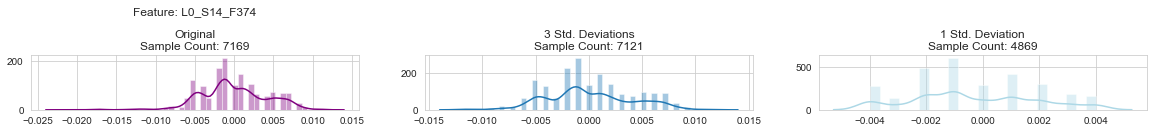

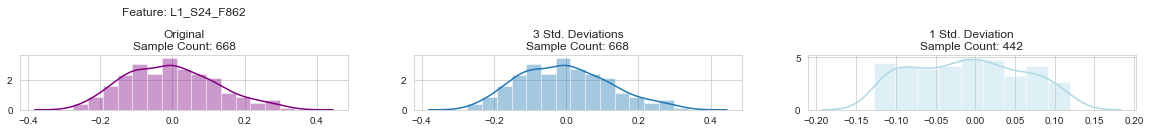

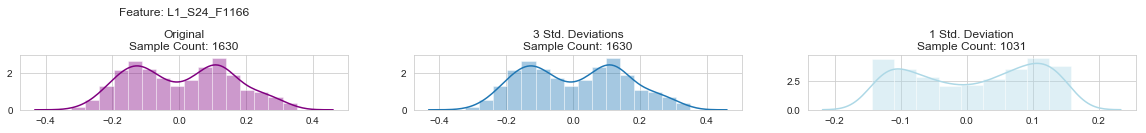

In [22]:
def plot_dist(df, col_index):
    c = df.columns[col_index]
    s_old = df[c].dropna()
    s_3 = df[c][np.abs(df[c]-df[c].mean()) <= (3*df[c].std())]
    s_1 = df[c][np.abs(df[c]-df[c].mean()) <= (1*df[c].std())]
    
    plt.figure(figsize=(20,1))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)
    
    plt.subplot(1, 3, 1)
    plt.title('Feature: {}\n\nOriginal\nSample Count: {}'.format(c,len(df[c].dropna())))
    sns.distplot(s_old,color='purple')
    plt.xlabel('')
    
    plt.subplot(1, 3, 2)
    plt.title('3 Std. Deviations\nSample Count: {}'.format(len(s_3.dropna())))
    sns.distplot(s_3)
    plt.xlabel('')

    plt.subplot(1, 3, 3)
    plt.title('1 Std. Deviation\nSample Count: {}'.format(len(s_1.dropna())))
    sns.distplot(s_1,color='lightblue')
    plt.xlabel('')
    
[plot_dist(mf_num_data,i) for i in [20,30,100,200,260]];

In [23]:
# finds 'nonnormal distributions'
nonnormal = []
for i,c in enumerate(columns_set):
    k,p = stats.normaltest(mf_num_data[c].dropna().values)
    if p >.001:
        nonnormal.append([c,i,p,k])           